In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from datetime import timedelta
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

/Users/nandhinichandran/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Data Preprocessing and Exploration

In [2]:
df_sales = pd.read_excel("/Users/nandhinichandran/Downloads/capstone_dominos/Sale.xlsx", engine='openpyxl')
ingredients_df = pd.read_excel("/Users/nandhinichandran/Downloads/capstone_dominos/ingredients.xlsx", engine='openpyxl')

In [3]:
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])
df_sales['order_time'] = pd.to_datetime(df_sales['order_time'], format='%H:%M:%S').dt.time
df_sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [4]:
df_sales.describe()

,pizza_id,order_id,quantity,order_date,unit_price,total_price
count,48620.000000,48620.000000,48620.000000,48620,48620.000000,48613.000000
mean,24310.500000,10701.479761,1.019622,2015-06-28 21:56:43.932538112,16.494132,16.821494
min,1.000000,1.000000,1.000000,2015-01-01 00:00:00,9.750000,9.750000
25%,12155.750000,5337.000000,1.000000,2015-03-30 00:00:00,12.750000,12.750000
50%,24310.500000,10682.500000,1.000000,2015-06-28 00:00:00,16.500000,16.500000
75%,36465.250000,16100.000000,1.000000,2015-09-29 00:00:00,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,2015-12-31 00:00:00,35.950000,83.000000
std,14035.529381,6180.119770,0.143077,NaN,3.621789,4.437520


In [5]:
df_sales.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [6]:
df_sales.duplicated().sum()

np.int64(0)

In [7]:
df_sales.nunique()

pizza_id             48620
order_id             21350
pizza_name_id           91
quantity                 4
order_date             358
order_time           16382
unit_price              25
total_price             56
pizza_size               5
pizza_category           4
pizza_ingredients       32
pizza_name              32
dtype: int64

# Handaling missing values

In [8]:
df_missing = df_sales[df_sales.isna().any(axis=1)]

In [9]:
# Missing values in pizza_name
df_missing[df_missing['pizza_name'].isna()]['pizza_name_id'].unique()

array(['pepperoni_s', 'hawaiian_s', 'mexicana_l', 'pepperoni_l',
       'sicilian_s', 'spicy_ital_m', 'big_meat_s'], dtype=object)

In [10]:
# We can substitue s with m or l to see if pizza_name is available
# List of pizza_name_id values to filter
pizza_ids_to_filter = ['pepperoni_m', 'hawaiian_m', 'mexicana_s', 'sicilian_m', 'spicy_ital_l', 'big_meat_s', 'big_meat_l']

# Filter DataFrame using the list of pizza_name_id values
filtered_df = df_sales[df_sales['pizza_name_id'].isin(pizza_ids_to_filter)]

# Drop duplicate entries based on 'pizza_name_id'
unique_filtered_df = filtered_df.drop_duplicates(subset='pizza_name_id')

unique_filtered_df

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
19,20,9,mexicana_s,1,2015-01-01,12:52:01,12.00,12.00,S,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
20,21,9,spicy_ital_l,1,2015-01-01,12:52:01,20.75,20.75,L,Supreme,"Capocollo, Tomatoes, Goat Cheese, Artichokes, ...",The Spicy Italian Pizza
35,36,15,big_meat_s,1,2015-01-01,13:33:00,12.00,12.00,S,Classic,"Bacon, Pepperoni, Italian Sausage, Chorizo Sau...",The Big Meat Pizza
64,65,24,pepperoni_m,1,2015-01-01,14:23:01,12.50,12.50,M,Classic,"Mozzarella Cheese, Pepperoni",The Pepperoni Pizza
66,67,25,sicilian_m,1,2015-01-01,14:44:44,16.25,16.25,M,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",The Sicilian Pizza


In [11]:
df_sales.loc[df_sales['pizza_name_id'] == 'hawaiian_s', 'pizza_name'] = 'The Hawaiian Pizza'
df_sales.loc[df_sales['pizza_name_id'] == 'pepperoni_s', 'pizza_name'] = 'The Pepperoni Pizza'
df_sales.loc[df_sales['pizza_name_id'] == 'pepperoni_l', 'pizza_name'] = 'The Pepperoni Pizza'
df_sales.loc[df_sales['pizza_name_id'] == 'mexicana_l', 'pizza_name'] = 'The Mexicana Pizza'
df_sales.loc[df_sales['pizza_name_id'] == 'sicilian_s', 'pizza_name'] = 'The Spicy Italian Pizza'
df_sales.loc[df_sales['pizza_name_id'] == 'spicy_ital_m', 'pizza_name'] = 'The Spicy Italian Pizza'
df_sales.loc[df_sales['pizza_name_id'] == 'big_meat_s', 'pizza_name'] = 'The Big Meat Pizza'

df_sales.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            0
dtype: int64

In [12]:
# Missing values in pizza_category
missing_category_pizza_names = (df_missing[df_missing['pizza_category'].isna()]['pizza_name'].unique()).tolist()
missing_category_pizza_names

['The Mexicana Pizza',
 'The Brie Carre Pizza',
 'The Pepper Salami Pizza',
 'The Napolitana Pizza',
 'The Spinach Pesto Pizza',
 'The Hawaiian Pizza',
 'The Sicilian Pizza',
 'The Spicy Italian Pizza',
 'The Barbecue Chicken Pizza',
 'The Chicken Alfredo Pizza',
 'The Pepperoni Pizza',
 'The Greek Pizza',
 'The Spinach and Feta Pizza',
 'The Italian Capocollo Pizza',
 'The Five Cheese Pizza',
 'The Prosciutto and Arugula Pizza']

In [13]:
# Filter DataFrame using the list of pizza_name_id values
filtered_df = df_sales[df_sales['pizza_name'].isin(missing_category_pizza_names)]

# Drop duplicate entries based on 'pizza_name_id'
unique_filtered_df = filtered_df.drop_duplicates(subset='pizza_name')

unique_filtered_df

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
7,8,3,prsc_argla_l,1,2015-01-01,12:12:28,20.75,20.75,L,Supreme,"Prosciutto di San Daniele, Arugula, Mozzarella...",The Prosciutto and Arugula Pizza
10,11,6,bbq_ckn_s,1,2015-01-01,12:29:36,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza
11,12,6,the_greek_s,1,2015-01-01,12:29:36,12.00,12.00,S,Classic,"Kalamata Olives, Feta Cheese, Tomatoes, Garlic...",The Greek Pizza
16,17,9,ital_cpcllo_l,1,2015-01-01,12:52:01,20.50,20.50,L,Classic,"Capocollo, Red Peppers, Tomatoes, Goat Cheese,...",The Italian Capocollo Pizza
20,21,9,spicy_ital_l,1,2015-01-01,12:52:01,20.75,20.75,L,Supreme,"Capocollo, Tomatoes, Goat Cheese, Artichokes, ...",The Spicy Italian Pizza
21,22,9,spin_pesto_l,1,2015-01-01,12:52:01,20.75,20.75,L,Veggie,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza
28,29,11,pepperoni_l,1,2015-01-01,13:02:59,15.25,15.25,L,Classic,"Mozzarella Cheese, Pepperoni",The Pepperoni Pizza


In [14]:
# Create a mapping from pizza_name to pizza_category
pizza_name_to_category = unique_filtered_df.set_index('pizza_name')['pizza_category'].to_dict()

In [15]:
# Fill missing pizza_category values in df_main
df_sales.loc[df_sales['pizza_name'].map(pizza_name_to_category).notna(), 'pizza_category'] = \
    df_sales['pizza_name'].map(pizza_name_to_category)

df_sales.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category        1
pizza_ingredients    13
pizza_name            0
dtype: int64

In [16]:
df_sales['pizza_category'].unique()

array(['Classic', 'Veggie', 'Supreme', 'Chicken', nan], dtype=object)

In [17]:
df_sales[df_sales['pizza_category'].isna()]['pizza_ingredients']

427    Brie Carre Cheese, Prosciutto, Caramelized Oni...
Name: pizza_ingredients, dtype: object

In [18]:
pd.set_option('display.max_colwidth', None)  # None means no truncation

In [19]:
df_sales[df_sales['pizza_category'].isna()]['pizza_ingredients']

427    Brie Carre Cheese, Prosciutto, Caramelized Onions, Pears, Thyme, Garlic
Name: pizza_ingredients, dtype: object

In [20]:
#we can put it under Supreme pizza as it is not a classic, regular veggie, or Chicken
df_sales.loc[df_sales['pizza_name'] == 'The Brie Carre Pizza', 'pizza_category'] = 'Supreme'

df_sales['pizza_category'].unique()

array(['Classic', 'Veggie', 'Supreme', 'Chicken'], dtype=object)

In [21]:
df_sales.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category        0
pizza_ingredients    13
pizza_name            0
dtype: int64

In [22]:
# Missing values in pizza_ingredients, we can likely drop this as we have ingredients in other table
df_missing[df_missing['pizza_ingredients'].isna()]['pizza_name'].unique()

array(['The Five Cheese Pizza', 'The Green Garden Pizza',
       'The Hawaiian Pizza', 'The Spinach and Feta Pizza',
       'The Pepperoni, Mushroom, and Peppers Pizza',
       'The California Chicken Pizza', 'The Four Cheese Pizza',
       'The Italian Vegetables Pizza', 'The Southwest Chicken Pizza',
       'The Chicken Alfredo Pizza', 'The Prosciutto and Arugula Pizza'],
      dtype=object)

In [23]:
# Missing values in total_price
missing_price_pizza_name_id = (df_missing[df_missing['total_price'].isna()]['pizza_name_id'].unique()).tolist()
missing_price_pizza_name_id

['bbq_ckn_m',
 'pepperoni_s',
 'sicilian_l',
 'southw_ckn_l',
 'five_cheese_l',
 'four_cheese_m',
 'ital_cpcllo_m']

In [24]:
df_missing[df_missing['total_price'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
781,782,341,bbq_ckn_m,1,2015-06-01,15:35:47,16.75,NaN,M,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers, Tomatoes, Red Onions, Barbecue Sauce",The Barbecue Chicken Pizza
782,783,341,pepperoni_s,1,2015-06-01,15:35:47,9.75,NaN,S,Classic,"Mozzarella Cheese, Pepperoni",The Pepperoni Pizza
783,784,342,sicilian_l,1,2015-06-01,15:44:12,20.25,NaN,L,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives, Luganega Sausage, Onions, Garlic",The Sicilian Pizza
784,785,342,southw_ckn_l,1,2015-06-01,15:44:12,20.75,NaN,L,Chicken,"Chicken, Tomatoes, Red Peppers, Red Onions, Jalapeno Peppers, Corn, Cilantro, Chipotle Sauce",The Southwest Chicken Pizza
785,786,343,five_cheese_l,1,2015-06-01,15:45:37,18.50,NaN,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Gouda Cheese, Romano Cheese, Blue Cheese, Garlic",The Five Cheese Pizza
786,787,343,four_cheese_m,1,2015-06-01,15:45:37,14.75,NaN,M,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mozzarella Cheese, Parmigiano Reggiano Cheese, Garlic",The Four Cheese Pizza
787,788,344,ital_cpcllo_m,1,2015-06-01,16:01:11,16.00,NaN,M,Classic,"Capocollo, Red Peppers, Tomatoes, Goat Cheese, Garlic, Oregano",The Italian Capocollo Pizza


In [25]:
df_sales.loc[df_sales['total_price'].isna(), 'total_price'] = df_sales['quantity'] * df_sales['unit_price']
df_sales.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients    13
pizza_name            0
dtype: int64

In [26]:
#Now dealing with the pizza_name_id
df_missing[df_missing['pizza_name_id'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
36,37,15,NaN,1,2015-01-01,13:33:00,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Gouda Cheese, Romano Cheese, Blue Cheese, Garlic",The Five Cheese Pizza
37,38,15,NaN,1,2015-01-01,13:33:00,20.75,20.75,L,Supreme,"Soppressata Salami, Fontina Cheese, Mozzarella Cheese, Mushrooms, Garlic",The Soppressata Pizza
38,39,15,NaN,1,2015-01-01,13:33:00,12.00,12.00,S,Classic,"Kalamata Olives, Feta Cheese, Tomatoes, Garlic, Beef Chuck Roast, Red Onions",The Greek Pizza
39,40,16,NaN,1,2015-01-01,13:34:07,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mozzarella Cheese, Parmigiano Reggiano Cheese, Garlic",The Four Cheese Pizza
40,41,16,NaN,1,2015-01-01,13:34:07,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions, Garlic",The Napolitana Pizza
41,42,16,NaN,1,2015-01-01,13:34:07,20.75,20.75,L,Chicken,"Chicken, Pineapple, Tomatoes, Red Peppers, Thai Sweet Chilli Sauce",The Thai Chicken Pizza
309,310,131,NaN,1,2015-02-01,21:33:10,12.00,12.00,S,Veggie,"Spinach, Mushrooms, Tomatoes, Green Olives, Feta Cheese",The Green Garden Pizza
310,311,131,NaN,1,2015-02-01,21:33:10,12.50,12.50,S,Supreme,"Spinach, Red Onions, Pepperoni, Tomatoes, Artichokes, Kalamata Olives, Garlic, Asiago Cheese",The Spinach Supreme Pizza
311,312,132,NaN,1,2015-02-01,21:42:45,9.75,9.75,S,Classic,"Mozzarella Cheese, Pepperoni",The Pepperoni Pizza
312,313,133,NaN,1,2015-02-01,22:00:17,20.75,20.75,L,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers, Tomatoes, Red Onions, Barbecue Sauce",The Barbecue Chicken Pizza


In [27]:
missing_pizza_name_id_pizza_name = (df_missing[df_missing['pizza_name_id'].isna()]['pizza_name'].unique()).tolist()
missing_pizza_name_id_pizza_name

['The Five Cheese Pizza',
 'The Soppressata Pizza',
 'The Greek Pizza',
 'The Four Cheese Pizza',
 'The Napolitana Pizza',
 'The Thai Chicken Pizza',
 'The Green Garden Pizza',
 'The Spinach Supreme Pizza',
 'The Pepperoni Pizza',
 'The Barbecue Chicken Pizza',
 'The Hawaiian Pizza',
 'The Italian Supreme Pizza',
 'The California Chicken Pizza',
 'The Pepper Salami Pizza']

In [28]:
# Filter DataFrame using the list of pizza_name_id values
filtered_df = df_sales[df_sales['pizza_name'].isin(missing_pizza_name_id_pizza_name)]

# Drop duplicate entries based on 'pizza_name_id'
unique_filtered_df = filtered_df.drop_duplicates(subset='pizza_name')

unique_filtered_df

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Gouda Cheese, Romano Cheese, Blue Cheese, Garlic",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Onions, Green Olives, Garlic",The Italian Supreme Pizza
5,6,2,thai_ckn_l,1,2015-01-01,11:57:40,20.75,20.75,L,Chicken,"Chicken, Pineapple, Tomatoes, Red Peppers, Thai Sweet Chilli Sauce",The Thai Chicken Pizza
10,11,6,bbq_ckn_s,1,2015-01-01,12:29:36,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers, Tomatoes, Red Onions, Barbecue Sauce",The Barbecue Chicken Pizza
11,12,6,the_greek_s,1,2015-01-01,12:29:36,12.00,12.00,S,Classic,"Kalamata Olives, Feta Cheese, Tomatoes, Garlic, Beef Chuck Roast, Red Onions",The Greek Pizza
12,13,7,spinach_supr_s,1,2015-01-01,12:50:37,12.50,12.50,S,Supreme,"Spinach, Red Onions, Pepperoni, Tomatoes, Artichokes, Kalamata Olives, Garlic, Asiago Cheese",The Spinach Supreme Pizza
15,16,9,green_garden_s,1,2015-01-01,12:52:01,12.00,12.00,S,Veggie,"Spinach, Mushrooms, Tomatoes, Green Olives, Feta Cheese",The Green Garden Pizza
26,27,11,cali_ckn_l,1,2015-01-01,13:02:59,20.75,20.75,L,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno Peppers, Fontina Cheese, Gouda Cheese",The California Chicken Pizza
28,29,11,pepperoni_l,1,2015-01-01,13:02:59,15.25,15.25,L,Classic,"Mozzarella Cheese, Pepperoni",The Pepperoni Pizza


In [29]:
pizza_name_id_map = unique_filtered_df.set_index('pizza_name')['pizza_name_id'].to_dict()

In [30]:
def adjust_pizza_name_id(pizza_name, pizza_size, pizza_name_id_map):
    # Check if pizza_name is in the map
    base_pizza_name_id = pizza_name_id_map.get(pizza_name, None)
    if pd.isna(base_pizza_name_id):
        return None

    # Ensure the base_pizza_name_id is a string
    base_pizza_name_id = str(base_pizza_name_id)
    
    size_mapping = {'S': 's', 'M': 'm', 'L': 'l'}
    if pizza_size in size_mapping:
        adjusted_pizza_name_id = base_pizza_name_id[:-1] + size_mapping[pizza_size]
        return adjusted_pizza_name_id
    else:
        return None

In [31]:
df_sales['pizza_name_id'] = df_sales.apply(lambda row: adjust_pizza_name_id(row['pizza_name'], row['pizza_size'], pizza_name_id_map) 
                               if pd.isna(row['pizza_name_id']) else row['pizza_name_id'], axis=1)


In [32]:
df_sales.isna().sum()

pizza_id              0
order_id              0
pizza_name_id         4
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients    13
pizza_name            0
dtype: int64

In [33]:
df_sales[df_sales['pizza_name_id'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
37,38,15,None,1,2015-01-01,13:33:00,20.75,20.75,L,Supreme,"Soppressata Salami, Fontina Cheese, Mozzarella Cheese, Mushrooms, Garlic",The Soppressata Pizza
39,40,16,None,1,2015-01-01,13:34:07,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mozzarella Cheese, Parmigiano Reggiano Cheese, Garlic",The Four Cheese Pizza
40,41,16,None,1,2015-01-01,13:34:07,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions, Garlic",The Napolitana Pizza
418,419,177,None,1,2015-03-01,17:54:36,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions, Garlic",The Napolitana Pizza


In [34]:
# 4 more null values let's see in ingridients column
ingredients_df[(ingredients_df['pizza_name']=='The Soppressata Pizza') | (ingredients_df['pizza_name']=='The Four Cheese Pizza') | (ingredients_df['pizza_name']=='The Napolitana Pizza') ]

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
124,four_cheese_l,The Four Cheese Pizza,Ricotta Cheese,50.0
125,four_cheese_l,The Four Cheese Pizza,Gorgonzola Piccante Cheese,40.0
126,four_cheese_l,The Four Cheese Pizza,Mozzarella Cheese,20.0
127,four_cheese_l,The Four Cheese Pizza,Parmigiano Reggiano Cheese,90.0
128,four_cheese_l,The Four Cheese Pizza,Garlic,15.0
129,four_cheese_m,The Four Cheese Pizza,Ricotta Cheese,25.0
130,four_cheese_m,The Four Cheese Pizza,Gorgonzola Piccante Cheese,20.0
131,four_cheese_m,The Four Cheese Pizza,Mozzarella Cheese,10.0
132,four_cheese_m,The Four Cheese Pizza,Parmigiano Reggiano Cheese,60.0
133,four_cheese_m,The Four Cheese Pizza,Garlic,10.0


In [35]:
df_sales.loc[(df_sales['pizza_name'] == 'The Four Cheese Pizza') & (df_sales['pizza_size'] == 'L'), 'pizza_name_id'] = 'four_cheese_l'
df_sales.loc[(df_sales['pizza_name'] == 'The Soppressata Pizza') & (df_sales['pizza_size'] == 'L'), 'pizza_name_id'] = 'soppressata_l'
df_sales.loc[(df_sales['pizza_name'] == 'The Napolitana Pizza') & (df_sales['pizza_size'] == 'S'), 'pizza_name_id'] = 'napolitana_s'

df_sales.isna().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients    13
pizza_name            0
dtype: int64

In [36]:
df_sales

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers, Bacon",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Gouda Cheese, Romano Cheese, Blue Cheese, Garlic",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Onions, Green Olives, Garlic",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red Onions, Cilantro, Corn, Chipotle Sauce, Garlic",The Mexicana Pizza
...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,2015-12-31,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, Asiago Cheese, Alfredo Sauce",The Chicken Alfredo Pizza
48616,48617,21348,four_cheese_l,1,2015-12-31,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mozzarella Cheese, Parmigiano Reggiano Cheese, Garlic",The Four Cheese Pizza
48617,48618,21348,napolitana_s,1,2015-12-31,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions, Garlic",The Napolitana Pizza
48618,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red Onions, Cilantro, Corn, Chipotle Sauce, Garlic",The Mexicana Pizza


In [38]:
df_sales.to_excel("/Users/nandhinichandran/Downloads/capstone_dominos/Pizza_Sale_Cleaned.xlsx", index=False)

In [39]:
ingredients_df.nunique()

pizza_name_id         91
pizza_name            32
pizza_ingredients     64
Items_Qty_In_Grams    17
dtype: int64

In [40]:
ingredients_df.isnull().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

In [41]:
ingredients_df[ingredients_df.isnull().any(axis=1)]

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [42]:
ingredients_df[ingredients_df['pizza_name'] == 'The Hawaiian Pizza']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
150,hawaiian_l,The Hawaiian Pizza,Pineapple,45.0
151,hawaiian_l,The Hawaiian Pizza,Mozzarella Cheese,30.0
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
153,hawaiian_m,The Hawaiian Pizza,Pineapple,30.0
154,hawaiian_m,The Hawaiian Pizza,Mozzarella Cheese,20.0
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN
156,hawaiian_s,The Hawaiian Pizza,Pineapple,15.0
157,hawaiian_s,The Hawaiian Pizza,Mozzarella Cheese,10.0


In [43]:
ingredients_df[ingredients_df['pizza_name'] == 'The Brie Carre Pizza']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
22,brie_carre_s,The Brie Carre Pizza,Brie Carre Cheese,30.0
23,brie_carre_s,The Brie Carre Pizza,Prosciutto,30.0
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
25,brie_carre_s,The Brie Carre Pizza,Pears,10.0
26,brie_carre_s,The Brie Carre Pizza,Thyme,5.0
27,brie_carre_s,The Brie Carre Pizza,Garlic,5.0


In [44]:
# Adding column size L or M or S 

ingredients_df['pizza_size'] = ingredients_df['pizza_name_id'].str[-1].str.upper()
ingredients_df

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,pizza_size
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,L
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,L
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,L
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,L
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,L
...,...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0,S
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0,S
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0,S
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0,S


In [45]:
# To fill them we can calculate avg total item qty weight in grams over all pizza for each size L, M, S then input them 

average_weight_by_size = ingredients_df.groupby('pizza_size')['Items_Qty_In_Grams'].mean()

print(average_weight_by_size)

#Thus we can round it off to the closest round number

pizza_size
L    45.000000
M    29.176829
S    16.279762
Name: Items_Qty_In_Grams, dtype: float64


In [46]:
# For pineapple

ingredients_df.loc[(ingredients_df['pizza_name_id'] == 'hawaiian_l') & (ingredients_df['pizza_ingredients'] == 'Sliced Ham'), 'Items_Qty_In_Grams'] = 45
ingredients_df.loc[(ingredients_df['pizza_name_id'] == 'hawaiian_m') & (ingredients_df['pizza_ingredients'] == 'Sliced Ham'), 'Items_Qty_In_Grams'] = 30
ingredients_df.loc[(ingredients_df['pizza_name_id'] == 'hawaiian_s') & (ingredients_df['pizza_ingredients'] == 'Sliced Ham'), 'Items_Qty_In_Grams'] = 15

ingredients_df[ingredients_df['pizza_name'] == 'The Hawaiian Pizza']


,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,pizza_size
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,45.0,L
150,hawaiian_l,The Hawaiian Pizza,Pineapple,45.0,L
151,hawaiian_l,The Hawaiian Pizza,Mozzarella Cheese,30.0,L
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,30.0,M
153,hawaiian_m,The Hawaiian Pizza,Pineapple,30.0,M
154,hawaiian_m,The Hawaiian Pizza,Mozzarella Cheese,20.0,M
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,15.0,S
156,hawaiian_s,The Hawaiian Pizza,Pineapple,15.0,S
157,hawaiian_s,The Hawaiian Pizza,Mozzarella Cheese,10.0,S


In [47]:
# for brie carre pizza 
ingredients_df.loc[(ingredients_df['pizza_name_id'] == 'brie_carre_s') & (ingredients_df['pizza_ingredients'] == 'Caramelized Onions'), 'Items_Qty_In_Grams'] = 15

ingredients_df[ingredients_df['pizza_name'] == 'The Brie Carre Pizza']


,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,pizza_size
22,brie_carre_s,The Brie Carre Pizza,Brie Carre Cheese,30.0,S
23,brie_carre_s,The Brie Carre Pizza,Prosciutto,30.0,S
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,15.0,S
25,brie_carre_s,The Brie Carre Pizza,Pears,10.0,S
26,brie_carre_s,The Brie Carre Pizza,Thyme,5.0,S
27,brie_carre_s,The Brie Carre Pizza,Garlic,5.0,S


In [48]:
ingredients_df.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
pizza_size            0
dtype: int64

In [50]:
ingredients_df.to_excel("/Users/nandhinichandran/Downloads/capstone_dominos/Pizza_ingredients_cleaned.xlsx",index=False)

In [52]:
import pandas as pd
sales_df = pd.read_excel("/Users/nandhinichandran/Downloads/capstone_dominos/Pizza_Sale_Cleaned.xlsx", engine='openpyxl')
ingredients_df = pd.read_excel("/Users/nandhinichandran/Downloads/capstone_dominos/Pizza_ingredients_cleaned.xlsx",engine='openpyxl')

In [53]:
sales_df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers, Bacon",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Gouda Cheese, Romano Cheese, Blue Cheese, Garlic",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Onions, Green Olives, Garlic",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red Onions, Cilantro, Corn, Chipotle Sauce, Garlic",The Mexicana Pizza


In [54]:
ingredients_df.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,pizza_size
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40,L
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15,L
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20,L
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30,L
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60,L


# Data Cleaning

In [55]:
# Data Cleaning
sales_df.dropna(subset=['pizza_name_id', 'pizza_category', 'pizza_ingredients', 'pizza_name'], inplace=True)
sales_df['total_price'] = sales_df['quantity'] * sales_df['unit_price']

# Handling outliers

In [56]:
# Handle outliers in 'quantity'
Q1 = sales_df['quantity'].quantile(0.25)
Q3 = sales_df['quantity'].quantile(0.75)
IQR = Q3 - Q1
sales_df = sales_df[(sales_df['quantity'] >= (Q1 - 1.5 * IQR)) & (sales_df['quantity'] <= (Q3 + 1.5 * IQR))]

In [57]:
# Convert order_date to datetime format
sales_df['order_date'] = pd.to_datetime(sales_df['order_date'], dayfirst=True, errors='coerce')

In [58]:
# Aggregate sales data by date
daily_sales = sales_df.groupby('order_date')['quantity'].sum().reset_index()

# Feature Engineering

In [59]:
# Feature Engineering
daily_sales['day_of_week'] = daily_sales['order_date'].dt.dayofweek
daily_sales['day_of_year'] = daily_sales['order_date'].dt.dayofyear
daily_sales['week_of_year'] = daily_sales['order_date'].dt.isocalendar().week
daily_sales['month'] = daily_sales['order_date'].dt.month

# Exploratory Data Analysis (EDA)

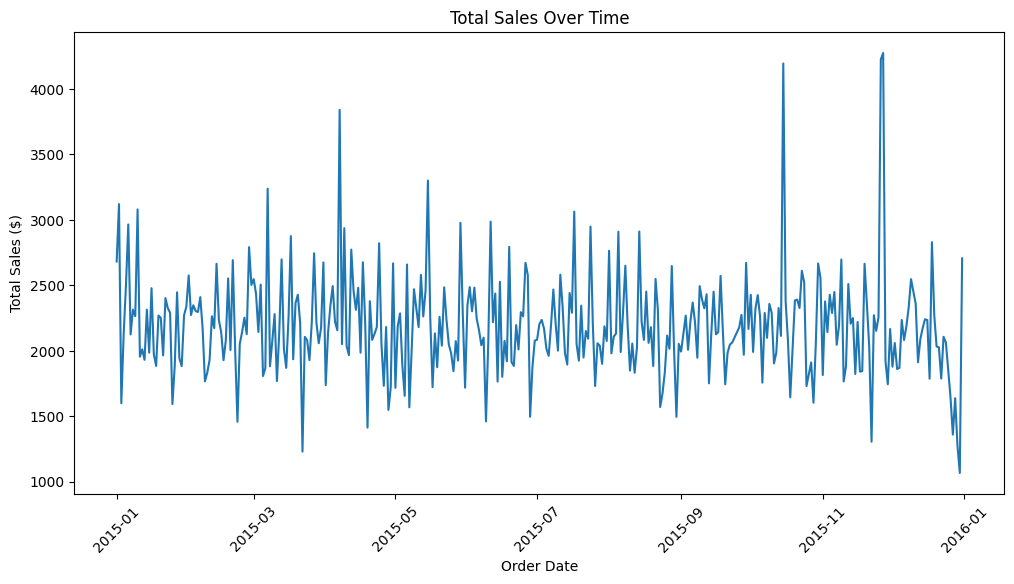

In [60]:
# 1. Total Sales Over Time
plt.figure(figsize=(12, 6))
sales_over_time = sales_df.groupby('order_date')['total_price'].sum()
sns.lineplot(data=sales_over_time)
plt.title('Total Sales Over Time')
plt.xlabel('Order Date')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.show()

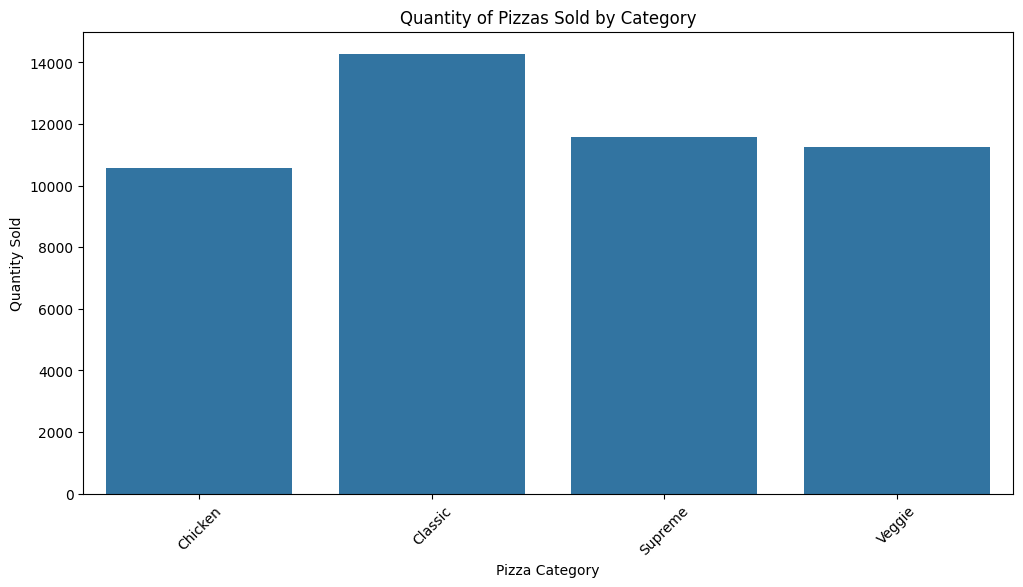

In [61]:
# 2. Quantity of Pizzas Sold by Category
plt.figure(figsize=(12, 6))
category_sales = sales_df.groupby('pizza_category')['quantity'].sum().reset_index()
sns.barplot(data=category_sales, x='pizza_category', y='quantity')
plt.title('Quantity of Pizzas Sold by Category')
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.show()

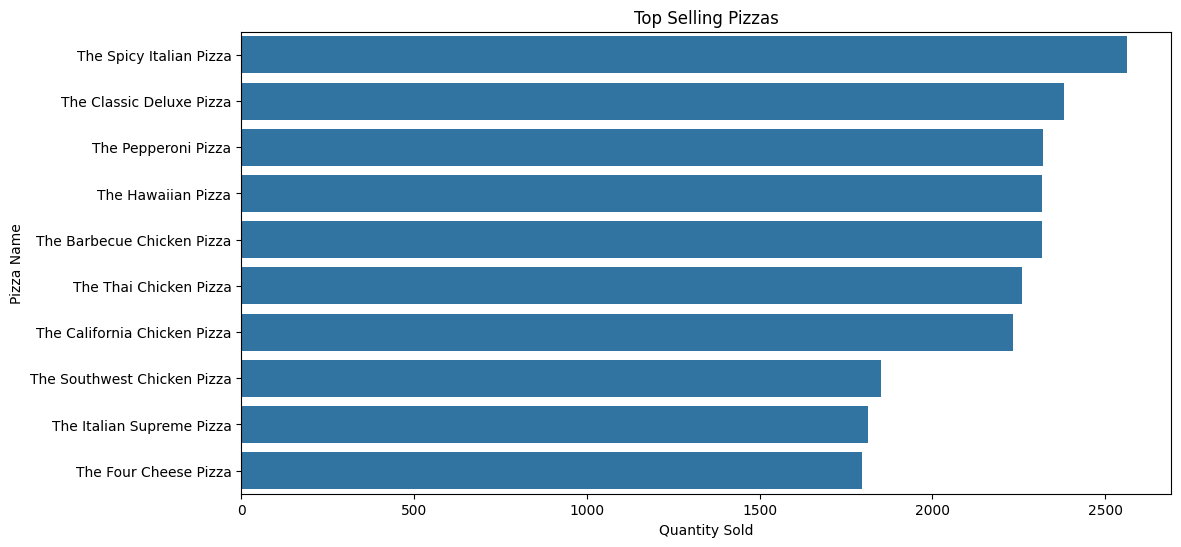

In [62]:
# 3. Top Selling Pizzas
plt.figure(figsize=(12, 6))
top_pizzas = sales_df.groupby('pizza_name')['quantity'].sum().nlargest(10).reset_index()
sns.barplot(data=top_pizzas, x='quantity', y='pizza_name')
plt.title('Top Selling Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

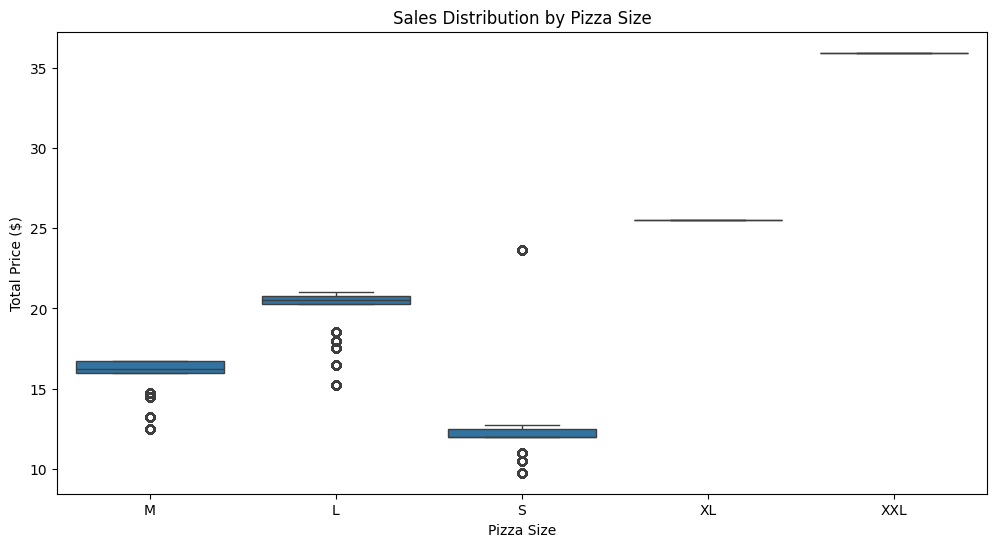

In [63]:
# 4. Sales Distribution by Pizza Size
plt.figure(figsize=(12, 6))
sns.boxplot(data=sales_df, x='pizza_size', y='total_price')
plt.title('Sales Distribution by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Total Price ($)')
plt.show()

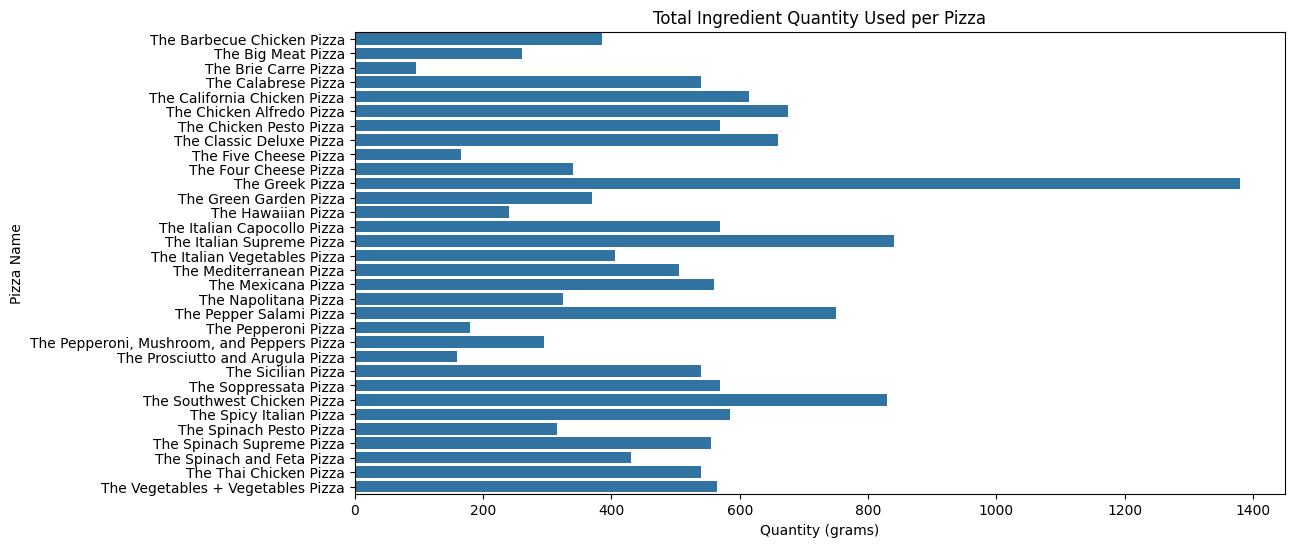

In [64]:
# 1. Quantity of Ingredients Used per Pizza
plt.figure(figsize=(12, 6))
ingredient_qty_per_pizza = ingredients_df.groupby('pizza_name')['Items_Qty_In_Grams'].sum().reset_index()
sns.barplot(data=ingredient_qty_per_pizza, x='Items_Qty_In_Grams', y='pizza_name')
plt.title('Total Ingredient Quantity Used per Pizza')
plt.xlabel('Quantity (grams)')
plt.ylabel('Pizza Name')
plt.show()

/var/folders/5w/qn7ft7217f17cypn4n49pgq80000gn/T/ipykernel_828/4083823227.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


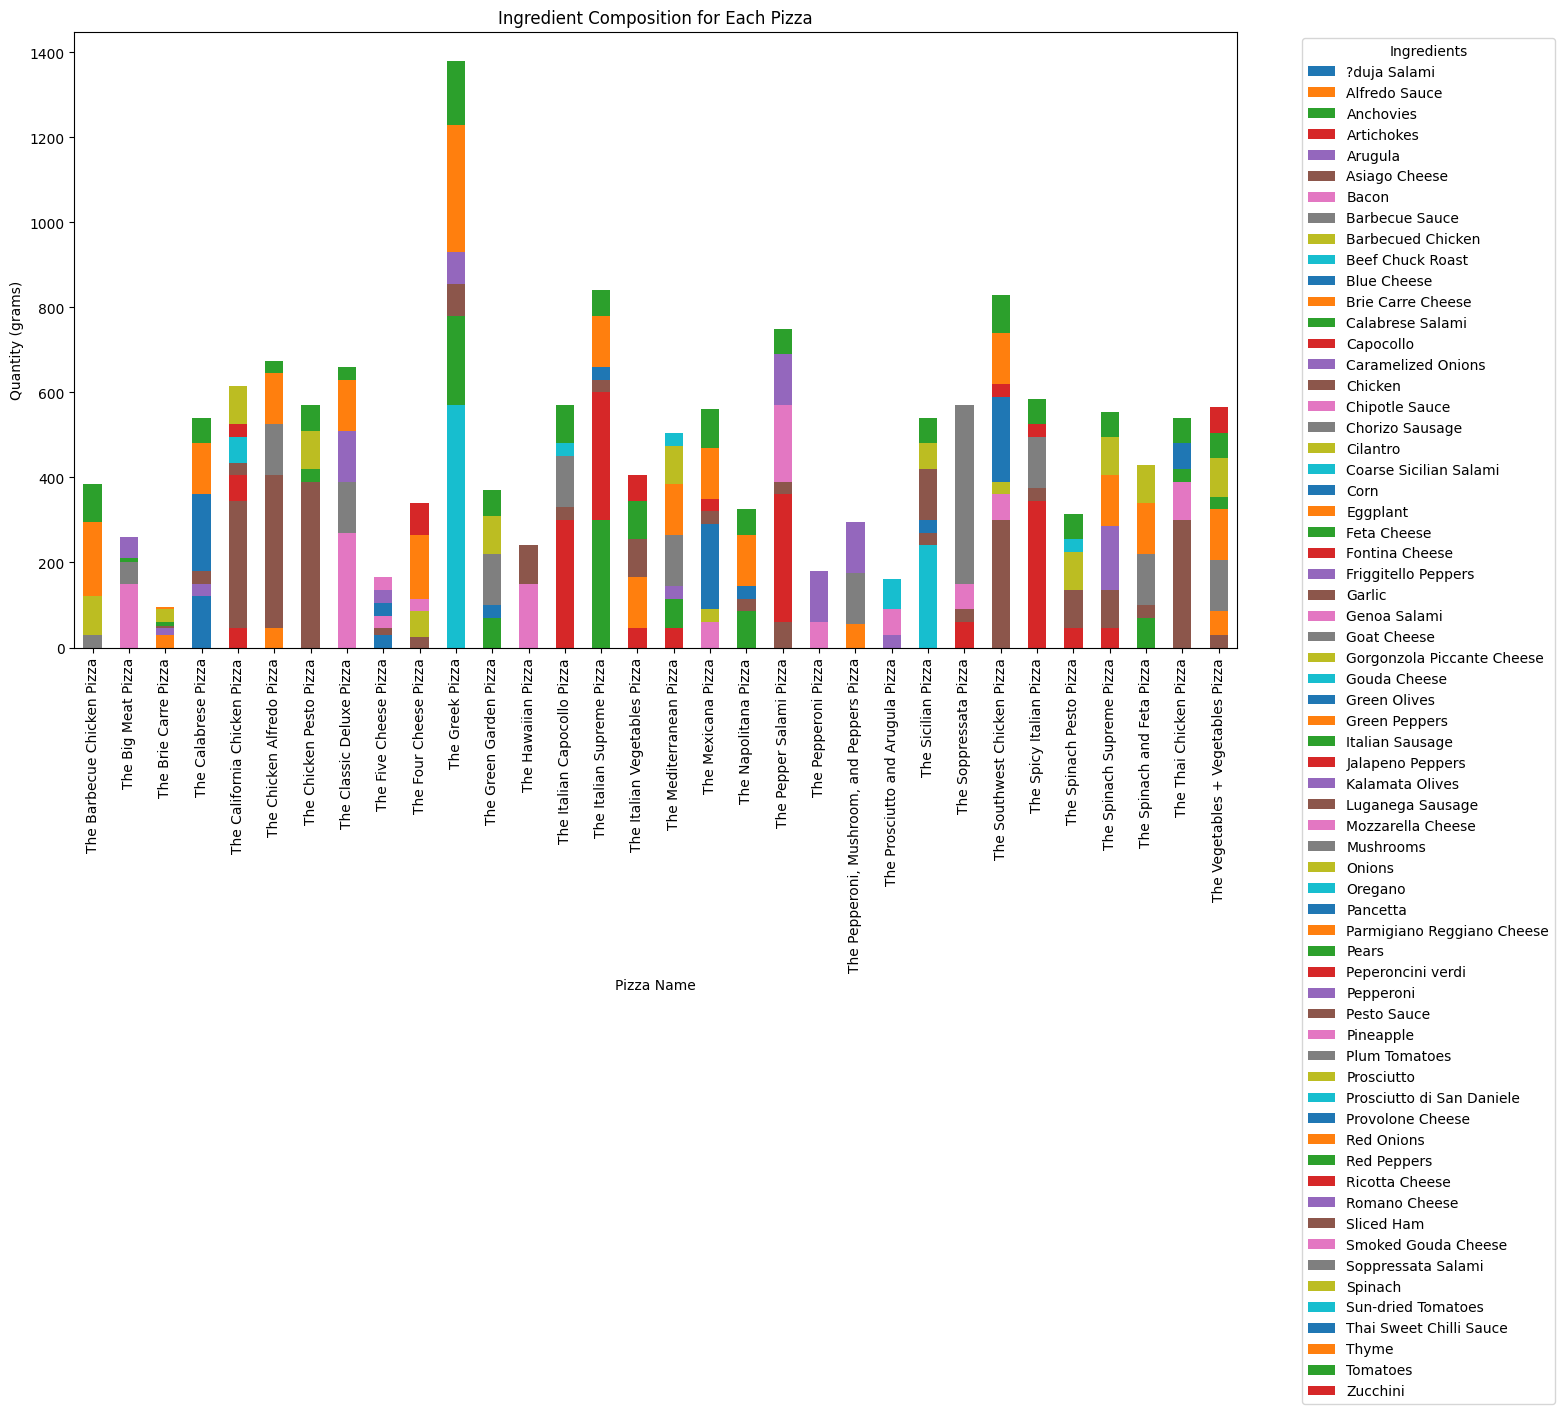

In [65]:
# 2. Ingredient Composition for Each Pizza
# This will create a stacked bar chart for ingredient quantities by pizza name.
ingredient_composition = ingredients_df.groupby(['pizza_name', 'pizza_ingredients'])['Items_Qty_In_Grams'].sum().unstack().fillna(0)

ingredient_composition.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Ingredient Composition for Each Pizza')
plt.xlabel('Pizza Name')
plt.ylabel('Quantity (grams)')
plt.legend(title='Ingredients', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

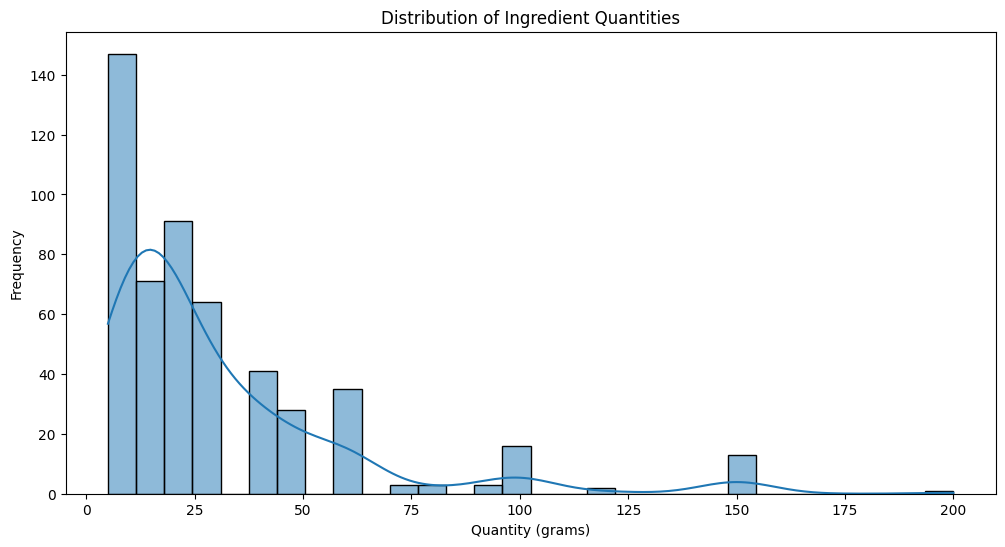

In [66]:
# 3. Distribution of Ingredient Quantities
plt.figure(figsize=(12, 6))
sns.histplot(ingredients_df['Items_Qty_In_Grams'], bins=30, kde=True)
plt.title('Distribution of Ingredient Quantities')
plt.xlabel('Quantity (grams)')
plt.ylabel('Frequency')
plt.show()

In [68]:
pip install skforecast

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 692 kB 672 kB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 364 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 28.8 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 172 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 1.8 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


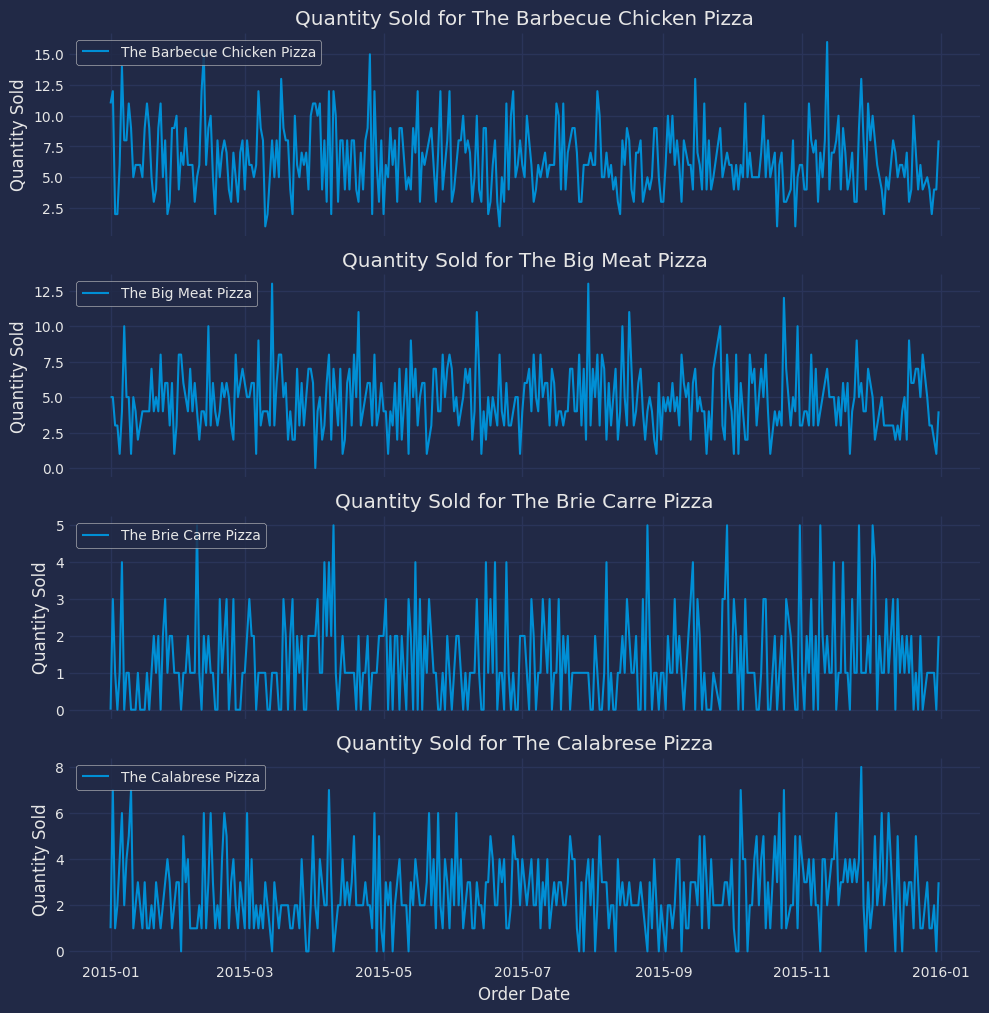

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import skforecast
from skforecast.plot import set_dark_theme


# Convert order_date to datetime
sales_df['order_date'] = pd.to_datetime(sales_df['order_date'])

# Aggregate quantity sold by date and pizza name
quantity_by_date = sales_df.groupby(['order_date', 'pizza_name'])['quantity'].sum().reset_index()

# Pivot the table to have dates as rows and pizza names as columns
pivot_df = quantity_by_date.pivot(index='order_date', columns='pizza_name', values='quantity').fillna(0)

# Select the first four pizzas (you can adjust this based on your actual pizza names)
first_four_pizzas = pivot_df.columns[:4]

# Plot time series for first 4 pizzas alone 
set_dark_theme()
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

for i, pizza in enumerate(first_four_pizzas):
    axs[i].plot(pivot_df.index, pivot_df[pizza], label=pizza)
    axs[i].set_title(f'Quantity Sold for {pizza}')
    axs[i].legend(loc='upper left')
    axs[i].set_ylabel('Quantity Sold')

fig.tight_layout()
plt.xlabel('Order Date')
plt.show()

# Train and Split

In [70]:
# Prepare the data for regression
X = daily_sales[['day_of_week', 'day_of_year', 'week_of_year', 'month']]
y = daily_sales['quantity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [71]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# 1. Linear Regression Model

In [72]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
regression_predictions = regression_model.predict(X_test)
regression_mape = mean_absolute_percentage_error(y_test, regression_predictions)
regression_mse = mean_squared_error(y_test, regression_predictions)
regression_mae = mean_absolute_error(y_test, regression_predictions)
regression_r2 = r2_score(y_test, regression_predictions)
regression_rmse = np.sqrt(regression_mse)
print(f"Linear Regression MAPE: {regression_mape}")
print(f"Linear Regression MSE: {regression_mse}")
print(f"Linear Regression MAE: {regression_mae}")
print(f"Linear Regression R2: {regression_r2}")
print(f"Linear Regression RMSE: {regression_rmse}")

Linear Regression MAPE: 0.16157410099380953
Linear Regression MSE: 907.2590986409085
Linear Regression MAE: 20.15555124913936
Linear Regression R2: -0.006855651516721517
Linear Regression RMSE: 30.120742000171717


# 2. ARIMA Model

In [73]:
arima_model = sm.tsa.ARIMA(y_train, order=(5, 1, 0))
arima_result = arima_model.fit()
arima_predictions = arima_result.forecast(steps=len(y_test))
arima_mape = mean_absolute_percentage_error(y_test, arima_predictions)
arima_mse = mean_squared_error(y_test, arima_predictions)
arima_mae = mean_absolute_error(y_test, arima_predictions)
arima_r2 = r2_score(y_test, arima_predictions)
arima_rmse = np.sqrt(arima_mse)
print(f"ARIMA MAPE: {arima_mape}")
print(f"ARIMA MSE: {arima_mse}")
print(f"ARIMA MAE: {arima_mae}")
print(f"ARIMA R2: {arima_r2}")
print(f"ARIMA RMSE: {arima_rmse}")

ARIMA MAPE: 0.3176045290280957
ARIMA MSE: 1848.4749179184737
ARIMA MAE: 36.28067945644765
ARIMA R2: -1.0513957044698228
ARIMA RMSE: 42.9938939608693


# 3. SARIMA Model

In [74]:
sarima_model = sm.tsa.SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
sarima_predictions = sarima_result.forecast(steps=len(y_test))
sarima_mape = mean_absolute_percentage_error(y_test, sarima_predictions)
sarima_mse = mean_squared_error(y_test, sarima_predictions)
sarima_mae = mean_absolute_error(y_test, sarima_predictions)
sarima_r2 = r2_score(y_test, sarima_predictions)
sarima_rmse = np.sqrt(sarima_mse)
print(f"SARIMA MAPE: {sarima_mape}")
print(f"SARIMA MSE: {sarima_mse}")
print(f"SARIMA MAE: {sarima_mae}")
print(f"SARIMA R2: {sarima_r2}")
print(f"SARIMA RMSE: {sarima_rmse}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.57251D+00    |proj g|=  9.06342D-02

At iterate    5    f=  4.49990D+00    |proj g|=  1.90268D-02


 This problem is unconstrained.



At iterate   10    f=  4.39486D+00    |proj g|=  4.39869D-03

At iterate   15    f=  4.39467D+00    |proj g|=  5.09708D-04

At iterate   20    f=  4.39459D+00    |proj g|=  5.93202D-03

At iterate   25    f=  4.39447D+00    |proj g|=  1.35071D-03

At iterate   30    f=  4.39446D+00    |proj g|=  1.62244D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     41      1     0     0   2.830D-06   4.394D+00
  F =   4.3944614966511697     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA MAPE: 0.17453123601259724
SARIMA MSE: 969.5535524871698
SARIMA MAE: 21.33897552175816
SARIMA R2: -0.075988

# 4. Decision Tree Regressor

In [75]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_mape = mean_absolute_percentage_error(y_test, dt_predictions)
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)
dt_rmse = np.sqrt(dt_mse)
print(f"Decision Tree MAPE: {dt_mape}")
print(f"Decision Tree MSE: {dt_mse}")
print(f"Decision Tree MAE: {dt_mae}")
print(f"Decision Tree R2: {dt_r2}")
print(f"Decision Tree RMSE: {dt_rmse}")

Decision Tree MAPE: 0.6471646129128674
Decision Tree MSE: 9420.652777777777
Decision Tree MAE: 77.48611111111111
Decision Tree R2: -9.454827628062725
Decision Tree RMSE: 97.06004727887668


# 5. Random Forest Regressor

In [76]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
print(f"Random Forest MAPE: {rf_mape}")
print(f"Random Forest MSE: {rf_mse}")
print(f"Random Forest MAE: {rf_mae}")
print(f"Random Forest R2: {rf_r2}")
print(f"Random Forest RMSE: {rf_rmse}")

Random Forest MAPE: 0.39916680824669587
Random Forest MSE: 2691.9509111111115
Random Forest MAE: 46.393055555555556
Random Forest R2: -1.987466306502795
Random Forest RMSE: 51.884014022732586


# 6. Gradient Boosting Regressor

In [77]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_mape = mean_absolute_percentage_error(y_test, gb_predictions)
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)
gb_rmse = np.sqrt(gb_mse)
print(f"Gradient Boosting MAPE: {gb_mape}")
print(f"Gradient Boosting MSE: {gb_mse}")
print(f"Gradient Boosting MAE: {gb_mae}")
print(f"Gradient Boosting R2: {gb_r2}")
print(f"Gradient Boosting RMSE: {gb_rmse}")

Gradient Boosting MAPE: 0.5347825636023811
Gradient Boosting MSE: 6156.208860097124
Gradient Boosting MAE: 63.7798908326764
Gradient Boosting R2: -5.832021516225569
Gradient Boosting RMSE: 78.4615119666778


# Scaling the features

In [78]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Scale the features
feature_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Scale the target variable
target_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

# LSTM

In [79]:
# Necessary Imports
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score

# Function to create the dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Create training and testing datasets
time_step = 10
X_train_lstm, y_train_lstm = create_dataset(y_train_scaled, time_step)
X_test_lstm, y_test_lstm = create_dataset(y_test_scaled, time_step)

# Reshape the data for LSTM [samples, time steps, features]
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

# Build the LSTM model using Input layer
model = Sequential([
    Input(shape=(time_step, 1)),  # Input layer specifying shape
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_lstm, y_train_lstm, batch_size=1, epochs=5)  # Increased epochs for better training

# Make predictions on the train and test sets
train_predict = model.predict(X_train_lstm)
test_predict = model.predict(X_test_lstm)

# Inverse transform to get actual values
train_predict = target_scaler.inverse_transform(train_predict)
test_predict = target_scaler.inverse_transform(test_predict)

# Calculate MAPE for test set predictions
y_test_inverse = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

# Check shapes before calculating metrics
print(f"Shape of true values (y_test_inverse): {y_test_inverse.shape}")
print(f"Shape of predictions (test_predict): {test_predict.shape}")

# Ensure both arrays have the same length before calculating metrics
if y_test_inverse.shape[0] == test_predict.shape[0]:
    lstm_mape = mean_absolute_percentage_error(y_test_inverse, test_predict)
    lstm_mse = mean_squared_error(y_test_inverse, test_predict)
    lstm_mae = mean_absolute_error(y_test_inverse, test_predict)
    lstm_rmse = np.sqrt(lstm_mse)
    lstm_r2 = r2_score(y_test_inverse, test_predict)

    print(f"LSTM MAPE: {lstm_mape}")
    print(f"LSTM MSE: {lstm_mse}")
    print(f"LSTM MAE: {lstm_mae}")
    print(f"LSTM RMSE: {lstm_rmse}")
    print(f"LSTM R²: {lstm_r2}")
else:
    print("Mismatch in lengths! Adjusting predictions...")
    
    # Truncate or pad predictions if necessary (example: truncate)
    min_length = min(y_test_inverse.shape[0], test_predict.shape[0])
    
    lstm_mape = mean_absolute_percentage_error(y_test_inverse[:min_length], test_predict[:min_length])
    lstm_mse = mean_squared_error(y_test_inverse[:min_length], test_predict[:min_length])
    lstm_mae = mean_absolute_error(y_test_inverse[:min_length], test_predict[:min_length])
    lstm_rmse = np.sqrt(lstm_mse)
    lstm_r2 = r2_score(y_test_inverse[:min_length], test_predict[:min_length])

    print(f"LSTM MAPE (adjusted): {lstm_mape}")
    print(f"LSTM MSE (adjusted): {lstm_mse}")
    print(f"LSTM MAE (adjusted): {lstm_mae}")
    print(f"LSTM RMSE (adjusted): {lstm_rmse}")
    print(f"LSTM R² (adjusted): {lstm_r2}")

Epoch 1/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0216
Epoch 2/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0190
Epoch 3/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173
Epoch 4/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171
Epoch 5/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0181
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Shape of true values (y_test_inverse): (72, 1)
Shape of predictions (test_predict): (62, 1)
Mismatch in lengths! Adjusting predictions...
LSTM MAPE (adjusted): 0.1309746552348204
LSTM MSE (adjusted): 830.2198091675236
LSTM MAE (adjusted): 18.43436075025989
LSTM RMSE (adjusted): 28.813535173031504
LSTM R² (adjusted): -0.022582009946512382


# Best model

In [80]:
# Choose the best model based on MAPE
mape_results = [
    (regression_mape, 'Linear Regression'),
    (arima_mape, 'ARIMA'),
    (sarima_mape, 'SARIMA'),
    (lstm_mape, 'LSTM'),
    (dt_mape, 'Decision Tree'),
    (rf_mape, 'Random Forest'),
    (gb_mape, 'Gradient Boosting')
]

best_model = min(mape_results)
print(f"Best Model: {best_model[1]} with MAPE: {best_model[0]}")

Best Model: LSTM with MAPE: 0.1309746552348204


# Sales Forecasting for the next week using the best model

In [81]:
# Sales Forecasting for the next week using the best model
last_date = daily_sales['order_date'].max()
future_dates = pd.DataFrame({
    'order_date': [last_date + timedelta(days=i) for i in range(1, 8)]
})
future_dates['day_of_week'] = future_dates['order_date'].dt.dayofweek
future_dates['day_of_year'] = future_dates['order_date'].dt.dayofyear
future_dates['week_of_year'] = future_dates['order_date'].dt.isocalendar().week
future_dates['month'] = future_dates['order_date'].dt.month

# Scale the features for LSTM prediction using historical data
last_n_days = daily_sales.tail(time_step)[['day_of_week', 'day_of_year', 'week_of_year', 'month']]

# Create a DataFrame for future predictions with historical data
combined_data = pd.concat([last_n_days, future_dates[['day_of_week', 'day_of_year', 'week_of_year', 'month']]], ignore_index=True)

# Check the shape of combined_data
print("Combined Data Shape:", combined_data.shape)

# Scale using feature_scaler
combined_scaled = feature_scaler.transform(combined_data)

# Check the shape after scaling
print("Shape of combined_scaled before reshaping:", combined_scaled.shape)

# Adjusting the reshape logic based on available data
num_samples = combined_scaled.shape[0] - time_step + 1  # Calculate how many complete sequences we can get

if num_samples > 0:
    # Create sequences from available data points 
    combined_sequences = []
    for i in range(num_samples):
        sequence = combined_scaled[i:i + time_step]  # Get sequence of length `time_step`
        combined_sequences.append(sequence[:, 0])   # Append only the first feature

    combined_sequences = np.array(combined_sequences)  # Convert list to numpy array

    # Reshape to match LSTM input requirements: (samples, time steps, features)
    combined_sequences = combined_sequences.reshape(combined_sequences.shape[0], time_step, 1) 

    # Make predictions using only as many sequences as there are future dates 
    future_sales_predictions = model.predict(combined_sequences[-7:])  

    # Inverse transform to get actual values
    future_sales_predictions = target_scaler.inverse_transform(future_sales_predictions)

else:
    raise ValueError("Not enough data points to create sequences for LSTM.")

# Combine predictions with future dates
future_sales = future_dates.copy()
future_sales['predicted_quantity'] = future_sales_predictions[:7]  # Ensure we only take first 7 predictions

print(future_sales[['order_date', 'predicted_quantity']])

Combined Data Shape: (17, 4)
Shape of combined_scaled before reshaping: (17, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
  order_date  predicted_quantity
0 2016-01-01          131.919678
1 2016-01-02          132.378952
2 2016-01-03          133.022690
3 2016-01-04          133.401947
4 2016-01-05          133.013641
5 2016-01-06          132.300446
6 2016-01-07          132.364227


# Predict the total quantity for each pizza type for the next week

In [82]:
# Predict the total quantity for each pizza type for the next week
predicted_pizza_sales = sales_df.groupby(['pizza_name_id', 'pizza_name', 'pizza_category', 'pizza_size'])['quantity'].sum().reset_index()
predicted_pizza_sales['predicted_quantity'] = predicted_pizza_sales['quantity'] * (future_sales['predicted_quantity'].sum() / sales_df['quantity'].sum())

# Merge the predicted pizza sales with the ingredient dataset
ingredient_requirements = predicted_pizza_sales.merge(ingredients_df, on='pizza_name_id', how='left')

# Calculate the total required quantity of each ingredient
ingredient_requirements['total_ingredient_qty'] = ingredient_requirements['predicted_quantity'] * ingredient_requirements['Items_Qty_In_Grams']

# Calculate ingredient requirements for one week, one month, and one year
ingredient_requirements['weekly_qty'] = ingredient_requirements['predicted_quantity'] / 7
ingredient_requirements['monthly_qty'] = ingredient_requirements['predicted_quantity'] * 4
ingredient_requirements['yearly_qty'] = ingredient_requirements['predicted_quantity'] * 52

# Initialize a DataFrame to accumulate weekly totals
weekly_totals_sum = pd.DataFrame()

# Print daily requirements for each day of the week
print("Daily, Weekly, Monthly, and Yearly Ingredient Requirements:")
for day in range(1, 8):  # Days 1 to 7
    print(f"Day {day}:")
    # Calculate the prediction factor for each day
    if day == 1:
        prediction_factor = 1.2  # Example: 20% higher than average
    elif day == 2:
        prediction_factor = 0.8  # Example: 20% lower than average
    elif day == 3:
        prediction_factor = 1.1  # Example: 10% higher than average
    else:
        prediction_factor = 1.0  # Average prediction for other days
    
    # Calculate the daily requirement for each ingredient
    daily_totals = ingredient_requirements.copy()
    daily_totals['daily_qty'] = daily_totals['predicted_quantity'] / 7 * prediction_factor
    daily_totals['Daily Requirement (grams)'] = daily_totals['daily_qty'] * daily_totals['Items_Qty_In_Grams']

    # Sum up the daily requirements for each ingredient
    daily_totals_sum = daily_totals.groupby('pizza_ingredients')['Daily Requirement (grams)'].sum().reset_index()

    # Calculate weekly, monthly, and yearly requirements
    weekly_totals_sum = daily_totals_sum.copy()
    weekly_totals_sum['Weekly Requirement (grams)'] = weekly_totals_sum['Daily Requirement (grams)'] * 7
    
    monthly_totals_sum = daily_totals_sum.copy()
    monthly_totals_sum['Monthly Requirement (grams)'] = weekly_totals_sum['Weekly Requirement (grams)'] * 4
    
    yearly_totals_sum = daily_totals_sum.copy()
    yearly_totals_sum['Yearly Requirement (grams)'] = weekly_totals_sum['Weekly Requirement (grams)'] * 52

    # Print the results for the day
    print(daily_totals_sum)

Daily, Weekly, Monthly, and Yearly Ingredient Requirements:
Day 1:
          pizza_ingredients  Daily Requirement (grams)
0              ?duja Salami                 133.986244
1             Alfredo Sauce                  50.169737
2                 Anchovies                 139.009894
3                Artichokes                 405.697262
4                   Arugula                  46.631486
..                      ...                        ...
59       Sun-dried Tomatoes                  61.201739
60  Thai Sweet Chilli Sauce                 179.215781
61                    Thyme                   7.844237
62                 Tomatoes                1913.626653
63                 Zucchini                 159.688638

[64 rows x 2 columns]
Day 2:
          pizza_ingredients  Daily Requirement (grams)
0              ?duja Salami                  89.324163
1             Alfredo Sauce                  33.446491
2                 Anchovies                  92.673262
3                Artich

# Weekly

In [83]:
weekly_totals_sum

,pizza_ingredients,Daily Requirement (grams),Weekly Requirement (grams)
0,?duja Salami,111.655203,781.586424
1,Alfredo Sauce,41.808114,292.656800
2,Anchovies,115.841578,810.891047
3,Artichokes,338.081052,2366.567362
4,Arugula,38.859571,272.016999
...,...,...,...
59,Sun-dried Tomatoes,51.001449,357.010141
60,Thai Sweet Chilli Sauce,149.346484,1045.425388
61,Thyme,6.536864,45.758049
62,Tomatoes,1594.688878,11162.822143


# Monthly

In [84]:
monthly_totals_sum

,pizza_ingredients,Daily Requirement (grams),Monthly Requirement (grams)
0,?duja Salami,111.655203,3126.345695
1,Alfredo Sauce,41.808114,1170.627200
2,Anchovies,115.841578,3243.564187
3,Artichokes,338.081052,9466.269450
4,Arugula,38.859571,1088.067996
...,...,...,...
59,Sun-dried Tomatoes,51.001449,1428.040566
60,Thai Sweet Chilli Sauce,149.346484,4181.701553
61,Thyme,6.536864,183.032197
62,Tomatoes,1594.688878,44651.288570


# Yearly

In [85]:
yearly_totals_sum

,pizza_ingredients,Daily Requirement (grams),Yearly Requirement (grams)
0,?duja Salami,111.655203,40642.494029
1,Alfredo Sauce,41.808114,15218.153594
2,Anchovies,115.841578,42166.334425
3,Artichokes,338.081052,123061.502847
4,Arugula,38.859571,14144.883946
...,...,...,...
59,Sun-dried Tomatoes,51.001449,18564.527355
60,Thai Sweet Chilli Sauce,149.346484,54362.120189
61,Thyme,6.536864,2379.418559
62,Tomatoes,1594.688878,580466.751414


# Purchase order for total weekly requirements

In [86]:
# Create purchase order DataFrame for total weekly requirements
purchase_order = weekly_totals_sum[['pizza_ingredients', 'Weekly Requirement (grams)']]
purchase_order.columns = ['Ingredient', 'Required Quantity (grams)']

In [87]:
purchase_order

,Ingredient,Required Quantity (grams)
0,?duja Salami,781.586424
1,Alfredo Sauce,292.656800
2,Anchovies,810.891047
3,Artichokes,2366.567362
4,Arugula,272.016999
...,...,...
59,Sun-dried Tomatoes,357.010141
60,Thai Sweet Chilli Sauce,1045.425388
61,Thyme,45.758049
62,Tomatoes,11162.822143


# Save the purchase order to a CSV file

In [89]:
# Save the purchase order to a CSV file
purchase_order.to_csv('/Users/nandhinichandran/Downloads/capstone_dominos/purchase_order.csv', index=False)

# Print confirmation message
print("\nTotal Purchase Order saved to 'purchase_order.csv'.")


Total Purchase Order saved to 'purchase_order.csv'.
